In [119]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import pandas as pd
# import ikpy.chain
# import ikpy.utils.plot as plot_utils
import itertools
import csv
import torch
import tqdm
# from chamferdist import ChamferDistance  # https://github.com/krrish94/chamferdist?tab=readme-ov-file
# import ChamferDistancePytorch.chamfer3D.dist_chamfer_3D
import kinematics
import utils
import network

In [158]:

N_USERS = 81
M_POSES = 1024  # Number of points for each point cloud
K_TASK_POINTS = 256   # Number of points to generate in task-space
LATENT_DIM = 64
LEARNING_RATE = 1e-4
EPOCHS = 3000
BATCH_SIZE = 64
BETA_KL = 0.001 # Weight for KL loss
TRAIN_SIZE   = math.floor(0.8 * N_USERS)
VAL_SIZE     = N_USERS - TRAIN_SIZE

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

raw_data = np.loadtxt("task_sp_points.csv", delimiter=',', skiprows=1)
raw_data = torch.tensor(raw_data[:, 1:], dtype=torch.float32)
raw_data = raw_data.view(N_USERS, -1, 3)  # [N_USERS, K_TASK_POINTS, 3]
raw_data.shape

train_dataset = raw_data[0:TRAIN_SIZE].to(device)
val_dataset   = raw_data[TRAIN_SIZE:N_USERS].to(device)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = network.fROM_VAE_task(joint_dim=3, latent_dim=LATENT_DIM, num_joint_points=M_POSES, num_task_points=256)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
chamfer_loss = utils.chamfer_loss

Using device: cuda


In [129]:
# get one batch of data and see shape
data_batch = train_dataset[0:BATCH_SIZE]
data_batch.shape  # [BATCH_SIZE, K_TASK_POINTS, 3]

torch.Size([64, 1024, 3])

In [159]:

for epoch in range(EPOCHS):
    model.train()
    total_loss_epoch = 0
    chamfer_loss_epoch = 0
    kl_loss_epoch = 0
    
    for pc in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training", unit="batch", leave=False):
        pc = pc.to(device) # [B, M, 3]
        optimizer.zero_grad()
        
        pc_recon, mu, logvar = model(pc)
        
        loss_chamfer = chamfer_loss(pc, pc_recon)
        loss_kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        loss = loss_chamfer + BETA_KL * loss_kld
        
        loss.backward()
        optimizer.step()
        
        total_loss_epoch += loss.item() * pc.size(0)
        chamfer_loss_epoch += loss_chamfer.item() * pc.size(0)
        kl_loss_epoch += loss_kld.item() * pc.size(0)
        
    if (epoch + 1) % 200 == 0:
        avg_train = total_loss_epoch / len(train_loader.dataset)
        avg_chamfer = chamfer_loss_epoch / len(train_loader.dataset)
        avg_kl = kl_loss_epoch / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {avg_train:.4f}, Chamfer Loss: {avg_chamfer:.4f}, KL Loss: {avg_kl:.4f}")

Epoch [200/3000] Train Loss: 0.2371, Chamfer Loss: 0.2371, KL Loss: 0.0853


Epoch [400/3000] Train Loss: 0.1371, Chamfer Loss: 0.1350, KL Loss: 2.1128


Epoch [600/3000] Train Loss: 0.1235, Chamfer Loss: 0.1210, KL Loss: 2.4815


Epoch [800/3000] Train Loss: 0.1022, Chamfer Loss: 0.0992, KL Loss: 2.9833


Epoch [1000/3000] Train Loss: 0.0902, Chamfer Loss: 0.0870, KL Loss: 3.2523


Epoch [1200/3000] Train Loss: 0.0796, Chamfer Loss: 0.0762, KL Loss: 3.4431


Epoch [1400/3000] Train Loss: 0.0732, Chamfer Loss: 0.0697, KL Loss: 3.5341


Epoch [1600/3000] Train Loss: 0.0684, Chamfer Loss: 0.0648, KL Loss: 3.5929


Epoch [1800/3000] Train Loss: 0.0653, Chamfer Loss: 0.0617, KL Loss: 3.6735


Epoch [2000/3000] Train Loss: 0.0629, Chamfer Loss: 0.0592, KL Loss: 3.6960


Epoch [2200/3000] Train Loss: 0.0612, Chamfer Loss: 0.0575, KL Loss: 3.7387


Epoch [2400/3000] Train Loss: 0.0595, Chamfer Loss: 0.0557, KL Loss: 3.7641


Epoch [2600/3000] Train Loss: 0.0579, Chamfer Loss: 0.0541, KL Loss: 3.7790


Epoch [2800/3000] Train Loss: 0.0566, Chamfer Loss: 0.0528, KL Loss: 3.7896


Epoch [3000/3000] Train Loss: 0.0553, Chamfer Loss: 0.0514, KL Loss: 3.8145


In [163]:

model.eval()
errors = 0.0

with torch.no_grad():
    for pc in tqdm.tqdm(val_loader, desc="Validation", unit="batch"):
        pc = pc.to(device)  # [B, M, 3]
        
        pc_recon, mu, logvar = model(pc)
        
        loss_chamfer = chamfer_loss(pc, pc_recon)
        loss_kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        loss = loss_chamfer + BETA_KL * loss_kld
        
        errors += loss.item() * pc.size(0)
avg_error = errors / len(val_loader.dataset)
print(f"Validation Loss: {avg_error:.4f}")

Validation: 100%|██████████| 1/1 [00:00<00:00, 18.84batch/s]

Validation Loss: 0.0470


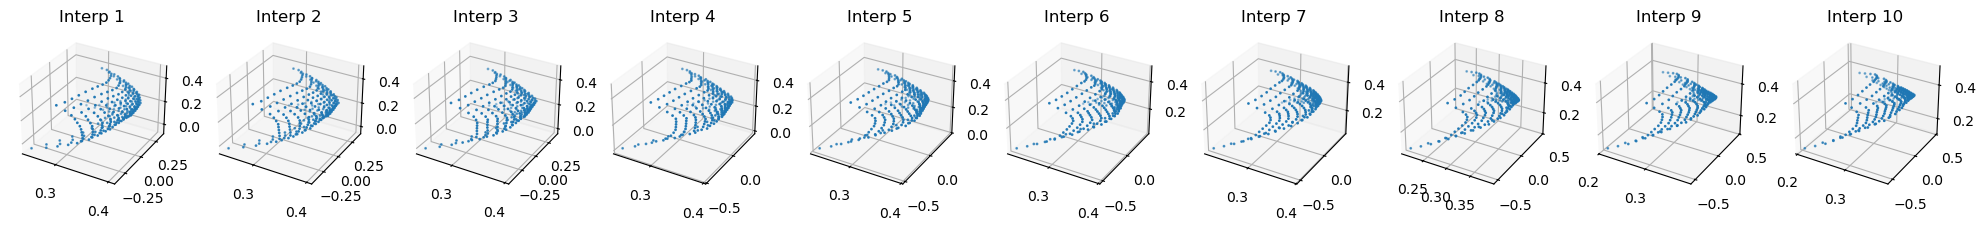

In [166]:
# sanity check, interpolate
with torch.no_grad():
    pc1 = val_dataset[0:1, :, :]  # [1, K_TASK_POINTS, 3]
    pc2 = val_dataset[4:5, :, :]  # [1, K_TASK_POINTS, 3]

    z1, _ = model.encoder(pc1)
    z2, _ = model.encoder(pc2)

    z_interp = torch.linspace(0, 1, steps=10).unsqueeze(1).to(device) * z2 + (1 - torch.linspace(0, 1, steps=10).unsqueeze(1).to(device)) * z1
    pc_interp = model.decoder(z_interp)  # [10, K_TASK_POINTS, 3]
    
    # pc1_prime = model.decoder(z1)
    # pc2_prime = model.decoder(z2)
    # pc_interp = torch.cat([pc1_prime, pc2_prime], dim=0)

    pc_interp = pc_interp.cpu().numpy()
    fig = plt.figure(figsize=(25, 5))
    for i in range(pc_interp.shape[0]):
        ax = fig.add_subplot(1, pc_interp.shape[0], i+1, projection='3d')
        ax.scatter(pc_interp[i, :, 0], pc_interp[i, :, 1], pc_interp[i, :, 2], s=1)
        ax.set_title(f"Interp {i+1}")
    plt.show()

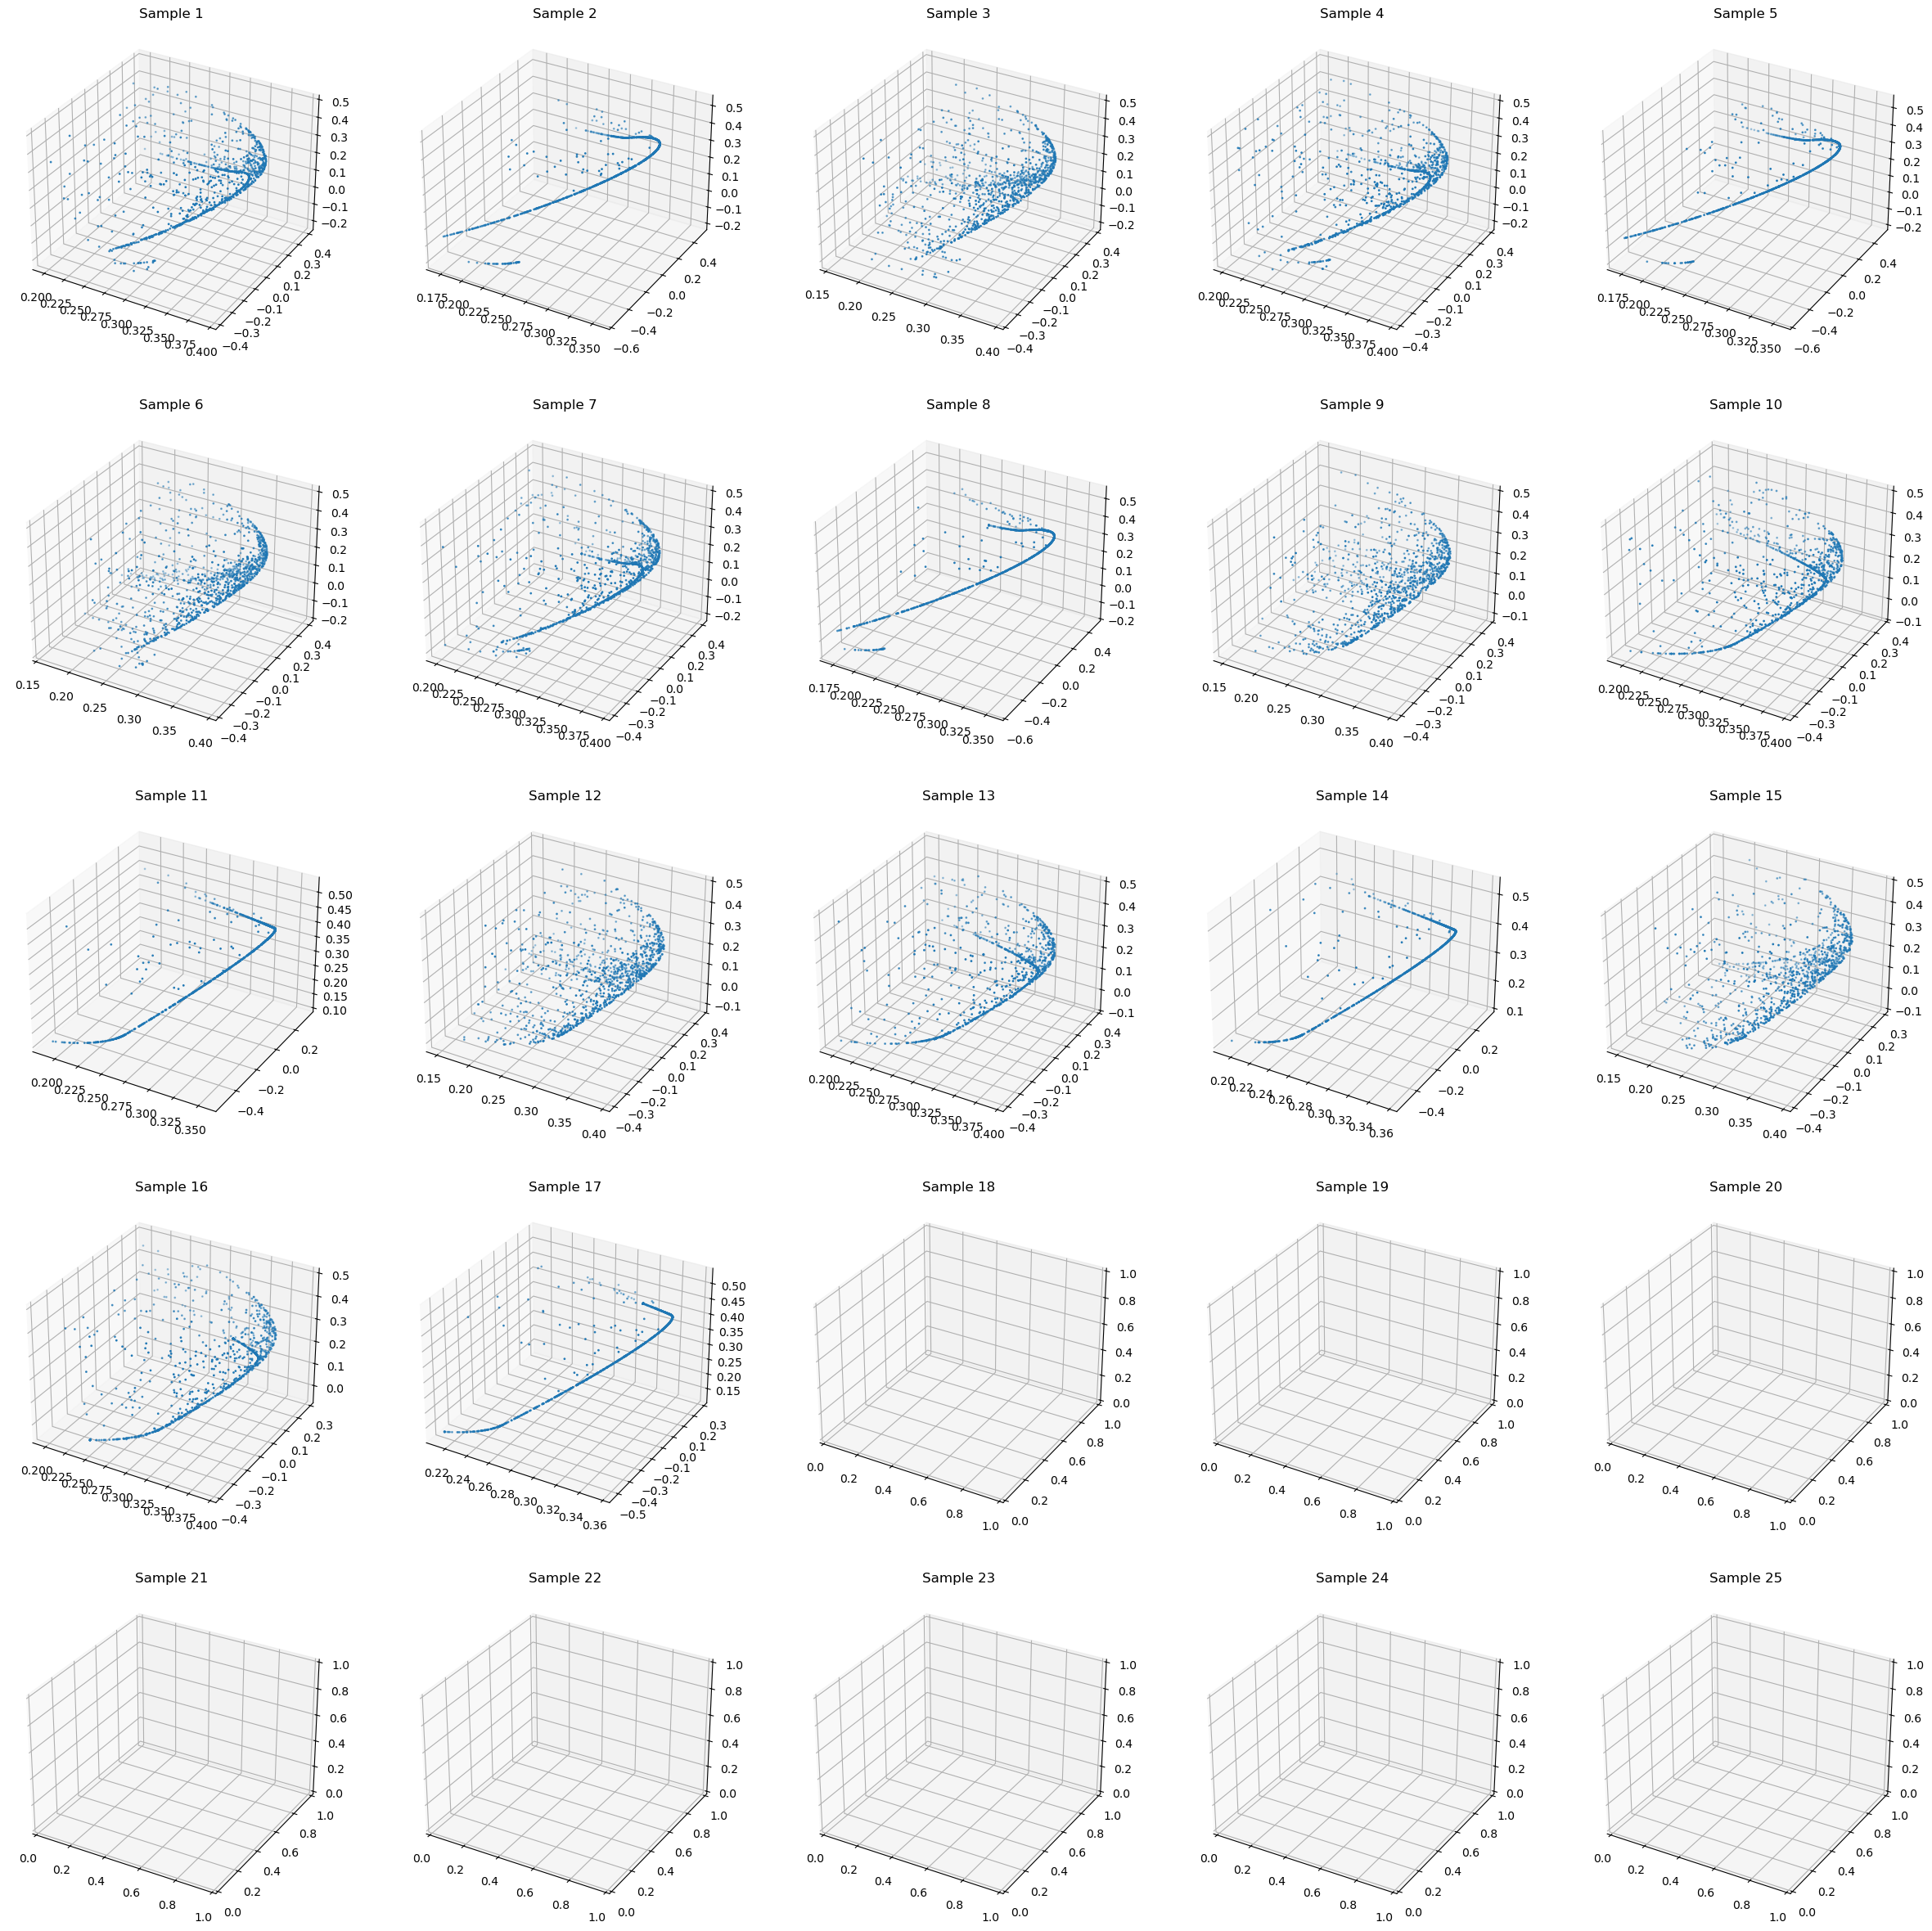

In [167]:
# visualize dataset
fig = plt.figure(figsize=(30, 30))
for i in range(25):
    ax = fig.add_subplot(5, 5, i+1, projection='3d')
    ax.scatter(val_dataset[i:i+1, :, 0].cpu(), val_dataset[i:i+1, :, 1].cpu(), val_dataset[i:i+1, :, 2].cpu(), s=1)
    ax.set_title(f"Sample {i+1}")
plt.show()
    

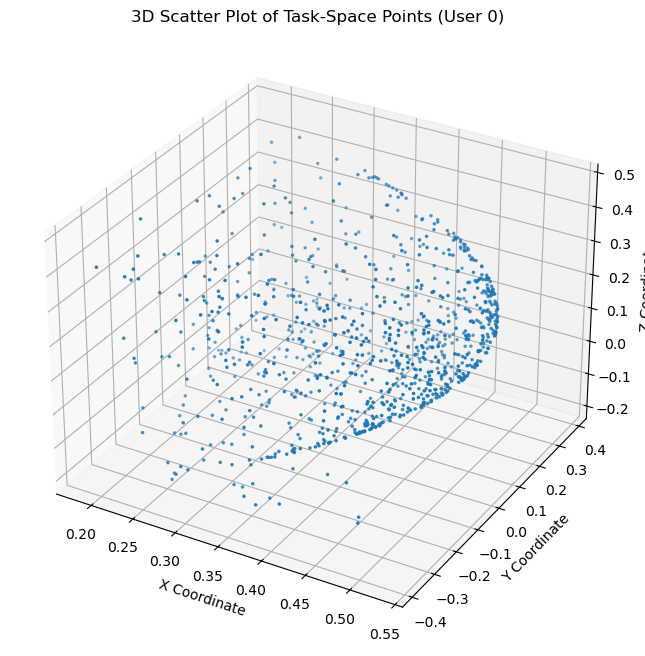

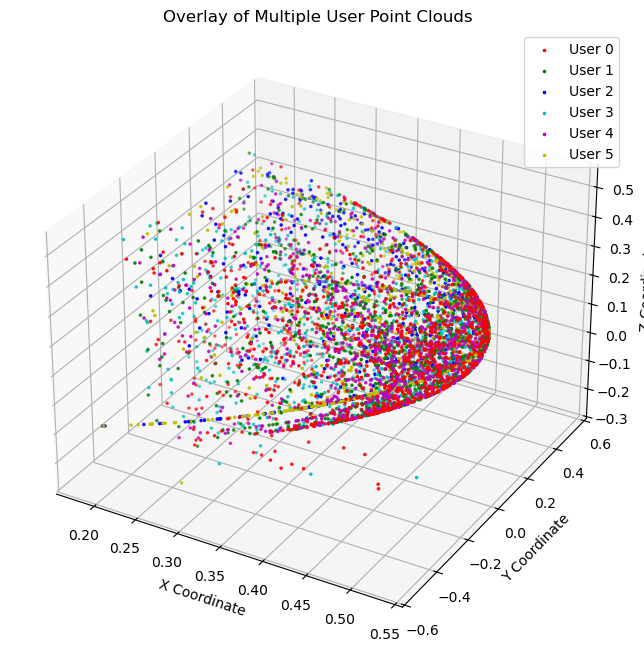

In [118]:
import matplotlib.pyplot as plt
import numpy as np

# Make sure raw_data is a numpy array on the CPU
# If raw_data is still a torch tensor, convert it:
# data_to_plot = raw_data.cpu().numpy()
data_to_plot = raw_data.numpy() # If it's a CPU tensor

# --- Plot a Single User's Point Cloud ---
pc = data_to_plot[0]  # Get the first user's data [256, 3]

# Extract x, y, z coordinates
x = pc[:, 0]
y = pc[:, 1]
z = pc[:, 2]

# Create the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, marker='.', s=10) # 's' is the marker size

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
ax.set_title('3D Scatter Plot of Task-Space Points (User 0)')
plt.show()

# --- (Optional) Plot Multiple Users ---
# This shows if all users share the same surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b', 'c', 'm', 'y']
for i in range(min(len(data_to_plot), 6)): # Plot up to 6 users
    pc = data_to_plot[i]
    ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], marker='.', s=10, c=colors[i], label=f'User {i}')

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
ax.set_title('Overlay of Multiple User Point Clouds')
ax.legend()
plt.show()

In [ ]:
# source_cloud = raw_data[0:5].to(device) 
# target_cloud = raw_data[0:5].to(device)

# loss = utils.chamfer_loss(source_cloud, target_cloud)

# print(f"Chamfer Loss (Pure PyTorch): {loss.item()}")

Chamfer Loss (Pure PyTorch): 5.127166514284909e-05


In [18]:
# print(f"Python Version: {os.sys.version}")
# print(f"PyTorch Version: {torch.__version__}")
# print(f"CUDA Version (PyTorch was built with): {torch.version.cuda}")
# print(f"Is CUDA available? {torch.cuda.is_available()}")